In [148]:
import ast # used for converting column values to lists post-import from csv
import re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

from wordcloud import WordCloud

import spacy

from nltk import FreqDist
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (roc_auc_score, plot_confusion_matrix, plot_roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.under_sampling import RandomUnderSampler

pd.set_option("display.max_columns", None)

In [149]:
df = pd.read_csv('data/recipes_for_preprocessing.cvs')

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482279 entries, 0 to 482278
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Unnamed: 0                482279 non-null  int64 
 1   id                        482279 non-null  int64 
 2   name                      482279 non-null  object
 3   description               482279 non-null  object
 4   ingredients               482279 non-null  object
 5   ingredients_raw_str       482279 non-null  object
 6   serving_size              482279 non-null  object
 7   servings                  482279 non-null  int64 
 8   steps                     482279 non-null  object
 9   tags                      482279 non-null  object
 10  search_terms              482279 non-null  object
 11  ingredients_list          482279 non-null  object
 12  ingredients_raw_str_list  482279 non-null  object
 13  steps_list                482279 non-null  object
 14  tags

In [151]:
df.head()

,Unnamed: 0,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,ingredients_list,ingredients_raw_str_list,steps_list,tags_list,search_terms_list,target_tag,target_search_term,target,num_ingredients,num_steps,num_char_description,cleaned_steps,step_tokens,cleaned_description,description_tokens
0,0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","{'diabetic', 'low-calorie', 'vegetarian', 'low...","['water', 'grits', 'salt', 'cheddar cheese', '...","['4 cups water', '1 cup uncooked old ...","['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","['low-calorie', 'diabetic', 'side', 'vegetaria...",False,False,0,6,4,301,i a sauce pan bring water to a boil slowly add...,"['i', 'a', 'sauce', 'pan', 'bring', 'water', '...",we love grits this is another good way to serv...,"['we', 'love', 'grits', 'this', 'is', 'another..."
1,1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'shrimp'}","['onion', 'red bell pepper', 'garlic cloves', ...","['1 medium onion, chopped coarse ', '1 ...","['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","['dinner', 'shrimp']",False,True,0,13,10,138,in a food processor pulse the onion red pepper...,"['in', 'a', 'food', 'processor', 'pulse', 'the...",simple easy and very tasty for when you are in...,"['simple', 'easy', 'and', 'very', 'tasty', 'fo..."
2,3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","{'side', 'vegetarian', 'italian'}","['zucchini', 'yellow squash', 'diced tomatoes'...","['2 zucchini, sliced ', '2 small ye...",['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","['italian', 'side', 'vegetarian']",True,False,0,9,1,57,put all ingredients in the crock pot and cook ...,"['put', 'all', 'ingredients', 'in', 'the', 'cr...",this is a good recipe for weight watchers it i...,"['this', 'is', 'a', 'good', 'recipe', 'for', '..."
3,4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",{'dinner'},"['beef stew meat', 'flour', 'salt', 'allspice'...","['3 lbs beef stew meat', '3 tablespoons...","['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",['dinner'],True,True,1,14,6,392,preheat oven to f cut beef into inch cubes com...,"['preheat', 'oven', 'to', 'f', 'cut', 'beef', ...",this is a fabulous stew that came from one of ...,"['this', 'is', 'a', 'fabulous', 'stew', 'that'..."
4,5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'preparation', 'des...",{'dessert'},"['slivered almonds', 'cider vinegar', 'sugar',...","['12 ounces slivered almonds', '1/4 cup ...",['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'prep

In [152]:
df['combined'] = df['description'] + ' ' + df['steps']

In [153]:
df.head()

,Unnamed: 0,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,ingredients_list,ingredients_raw_str_list,steps_list,tags_list,search_terms_list,target_tag,target_search_term,target,num_ingredients,num_steps,num_char_description,cleaned_steps,step_tokens,cleaned_description,description_tokens,combined
0,0,96313,Grilled Garlic Cheese Grits,"We love grits, this is another good way to ser...","['water', 'grits', 'salt', 'cheddar cheese', '...","[""4 cups water"",""1 cup uncooked old f...",1 (155 g),8,"['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","{'diabetic', 'low-calorie', 'vegetarian', 'low...","['water', 'grits', 'salt', 'cheddar cheese', '...","['4 cups water', '1 cup uncooked old ...","['I a sauce pan, bring water to a boil; slowly...","['time-to-make', 'course', 'main-ingredient', ...","['low-calorie', 'diabetic', 'side', 'vegetaria...",False,False,0,6,4,301,i a sauce pan bring water to a boil slowly add...,"['i', 'a', 'sauce', 'pan', 'bring', 'water', '...",we love grits this is another good way to serv...,"['we', 'love', 'grits', 'this', 'is', 'another...","We love grits, this is another good way to ser..."
1,1,232037,Simple Shrimp and Andouille Jambalaya,"Simple, easy and very tasty for when you are i...","['onion', 'red bell pepper', 'garlic cloves', ...","[""1 medium onion, chopped coarse "",""1 m...",1 (366 g),4,"['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'shrimp'}","['onion', 'red bell pepper', 'garlic cloves', ...","['1 medium onion, chopped coarse ', '1 ...","['In a food processor, pulse the onion, red pe...","['60-minutes-or-less', 'time-to-make', 'course...","['dinner', 'shrimp']",False,True,0,13,10,138,in a food processor pulse the onion red pepper...,"['in', 'a', 'food', 'processor', 'pulse', 'the...",simple easy and very tasty for when you are in...,"['simple', 'easy', 'and', 'very', 'tasty', 'fo...","Simple, easy and very tasty for when you are i..."
2,3,60656,Crock Pot Italian Zucchini,This is a good recipe for weight watchers. It ...,"['zucchini', 'yellow squash', 'diced tomatoes'...","[""2 zucchini, sliced "",""2 small yel...",1 (244 g),4,['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","{'side', 'vegetarian', 'italian'}","['zucchini', 'yellow squash', 'diced tomatoes'...","['2 zucchini, sliced ', '2 small ye...",['Put all ingredients in the crock pot and coo...,"['weeknight', 'time-to-make', 'course', 'main-...","['italian', 'side', 'vegetarian']",True,False,0,9,1,57,put all ingredients in the crock pot and cook ...,"['put', 'all', 'ingredients', 'in', 'the', 'cr...",this is a good recipe for weight watchers it i...,"['this', 'is', 'a', 'good', 'recipe', 'for', '...",This is a good recipe for weight watchers. It ...
3,4,232047,Beef Stew With Dried Cherries,This is a fabulous stew that came from one of ...,"['beef stew meat', 'flour', 'salt', 'allspice'...","[""3 lbs beef stew meat"",""3 tablespoons ...",1 (358 g),8,"['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",{'dinner'},"['beef stew meat', 'flour', 'salt', 'allspice'...","['3 lbs beef stew meat', '3 tablespoons...","['Preheat oven to 350°F.', ""Cut beef into 1 in...","['time-to-make', 'course', 'main-ingredient', ...",['dinner'],True,True,1,14,6,392,preheat oven to f cut beef into inch cubes com...,"['preheat', 'oven', 'to', 'f', 'cut', 'beef', ...",this is a fabulous stew that came from one of ...,"['this', 'is', 'a', 'fabulous', 'stew', 'that'...",This is a fabulous stew that came from one of ...
4,5,232050,Hot Sweet Almond Brittle,This is one of our standard holiday gift recip...,"['slivered almonds', 'cider vinegar', 'sugar',...","[""12 ounces slivered almonds"",""1/4 cup ...",1 (832 g),1,['Preheat oven to 375°F Place almonds in sing...,"['time-to-make', 'course', 'pr

In [154]:
y = df['target']

In [155]:
X = pd.DataFrame(df['combined'], index = df.index)

In [156]:
X.head()

,combined
0,"We love grits, this is another good way to ser..."
1,"Simple, easy and very tasty for when you are i..."
2,This is a good recipe for weight watchers. It ...
3,This is a fabulous stew that came from one of ...
4,This is one of our standard holiday gift recip...


In [157]:
len(y)

482279

In [158]:
df_sample = df.sample(50000)
len(df_sample)

50000

In [159]:
df_sample.head()

,Unnamed: 0,id,name,description,ingredients,ingredients_raw_str,serving_size,servings,steps,tags,search_terms,ingredients_list,ingredients_raw_str_list,steps_list,tags_list,search_terms_list,target_tag,target_search_term,target,num_ingredients,num_steps,num_char_description,cleaned_steps,step_tokens,cleaned_description,description_tokens,combined
394829,405412,245688,Easy Shepherds Pie,This is a great recipe thats easy to prepare w...,"['ground beef', 'instant mashed potatoes', 'fr...","[""1 lb ground beef"",""1 (20 ounce) box ...",1 (430 g),3,"[""Preheat Oven to 325'F."", 'Use vegetable spra...","['60-minutes-or-less', 'time-to-make', 'course...","{'dinner', 'low-sodium'}","['ground beef', 'instant mashed potatoes', 'fr...","['1 lb ground beef', '1 (20 ounce) box ...","[""Preheat Oven to 325'F."", 'Use vegetable spra...","['60-minutes-or-less', 'time-to-make', 'course...","['dinner', 'low-sodium']",False,True,0,8,19,117,preheat oven to f use vegetable spray on casse...,"['preheat', 'oven', 'to', 'f', 'use', 'vegetab...",this is a great recipe thats easy to prepare w...,"['this', 'is', 'a', 'great', 'recipe', 'thats'...",This is a great recipe thats easy to prepare w...
287952,294949,444120,French Onion Soup,Courtesy of Paula Dean,"['onions', 'garlic cloves', 'olive oil', 'all-...","[""8 onions"",""4 garlic cloves"",""1/3...",1 (487 g),6,['Saute onions and garlic in oil over low heat...,"['60-minutes-or-less', 'time-to-make', 'course...","{'french', 'soup'}","['onions', 'garlic cloves', 'olive oil', 'all-...","['8 onions', '4 garlic cloves', '1...",['Saute onions and garlic in oil over low heat...,"['60-minutes-or-less', 'time-to-make', 'course...","['soup', 'french']",False,False,0,12,9,22,saute onions and garlic in oil over low heat u...,"['saute', 'onions', 'and', 'garlic', 'in', 'oi...",courtesy of paula dean,"['courtesy', 'of', 'paula', 'dean']",Courtesy of Paula Dean ['Saute onions and garl...
336486,345133,467734,So Easy Sweet Potato and Squash Soup,Warm up with a delicious Fall soup that brings...,"['sweet potatoes', 'butternut squash soup', 'u...","[""1 sweet potatoes or 1 yam, peele...",1 (47 g),4,['In a large pot add about an inch of water an...,"['30-minutes-or-less', 'time-to-make', 'prepar...","{'dessert', 'soup', 'vegetarian', 'vegan'}","['sweet potatoes', 'butternut squash soup', 'u...","['1 sweet potatoes or 1 yam, peele...",['In a large pot add about an inch of water an...,"['30-minutes-or-less', 'time-to-make', 'prepar...","['vegan', 'soup', 'dessert', 'vegetarian']",True,False,0,4,4,278,in a large pot add about an inch of water and ...,"['in', 'a', 'large', 'pot', 'add', 'about', 'a...",warm up with a delicious fall soup that brings...,"['warm', 'up', 'with', 'a', 'delicious', 'fall...",Warm up with a delicious Fall soup that brings...
476566,489133,208756,Broccoli Cheese Souffle,Nice and light side dish. Left overs are great...,"['onion', 'butter', 'flour', 'milk', 'nutmeg',...","[""1 onion, finely chopped "",""4 tablesp...",1 (100 g),6,"['Preheat oven to 350 F, fill round cake pan o...","['time-to-make', 'course', 'preparation', 'bre...","{'breakfast', 'side', 'low-carb'}","['onion', 'butter', 'flour', 'milk', 'nutmeg',...","['1 onion, finely chopped ', '4 tables...","['Preheat oven to 350 F, fill round cake pan o...","['time-to-make', 'course', 'preparation', 'bre...","['side', 'breakfast', 'low-carb']",False,False,0,8,11,71,preheat oven to f fill round cake pan or pie p...,"['preheat', 'oven', 'to', 'f', 'fill', 'round'...",nice and light side dish left overs are great ...,"['nice', 'and', 'light', 'side', 'dish', 'left...",Nice and light side dish. Left overs are great...
466129,478468,406505,Marshmallow Milkshake,Top with a toasted marshmallow or two. Also c...,"['ice cream', 'milk', 'marshmallow creme', 'va...","[""3 scoops vanilla soft serve ice cream"",""...",1 (183 g),1,['Blend all ingredients with blender. Serve.'],"['weeknight', '15-minutes-or-less', 'time-to-m...",{'dessert'},"['ice cream', 'mi

In [160]:
y_sample = df_sample['target']
len(y_sample)

50000

In [161]:
X_sample = pd.DataFrame(df_sample['combined'], index = df_sample.index)

In [162]:
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X,y)
y_res.value_counts()

0    98067
1    98067
Name: target, dtype: int64

In [163]:
X_sample_rus, y_sample_rus = rus.fit_resample(X_sample, y_sample)
y_sample_rus.value_counts()

0    10190
1    10190
Name: target, dtype: int64

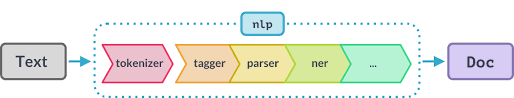

above from spacy documentation and process we'll emulate below
https://spacy.io/usage/processing-pipelines

# Tokenization 

In [164]:
X_sample_rus.head()

,combined
0,"This comes from a 1960's book, sponsored by th..."
1,"I had a request to make ""real"" Jewish Rye Brea..."
2,Artichokes give this dish a meaty texture and ...
3,This is a great soup for Weight Watchers who w...
4,"A sweet, creamy, vanilla Coke. ['Fill glass wi..."


In [287]:
cook_words = {'garlic', 'milk', 'pepper', 'garlic cloves', 'salt', 'lemon juice', 'brown sugar', 'flour', 'parmesan cheese', 'eggs', 'onion', 'salt and pepper', 'butter', 'sugar', 'water', 'olive oil', 'vegetable oil'}

In [292]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) # disabling what we don't need to lemmatize
nlp.Defaults.stop_words |= cook_words

In [293]:
test = X_sample_rus.head(10)

In [145]:
X_sample_rus['lowercase'] = X_sample_rus['combined'].apply(lambda x: x.lower())

In [179]:
X_sample_rus.head(3)

,combined
0,"This comes from a 1960's book, sponsored by th..."
1,"I had a request to make ""real"" Jewish Rye Brea..."
2,Artichokes give this dish a meaty texture and ...


In [178]:
X_sample_rus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20380 entries, 0 to 20379
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   combined  20380 non-null  object
dtypes: object(1)
memory usage: 159.3+ KB


In [176]:
X_sample_rus['lemma'] = X_sample_rus['combined'].apply(lambda x: ' '.join([y.lemma_ for y in nlp(x) if not y.is_stop]))

KeyError: 'lowercase'

In [175]:
# test['lemma'] = test['lowercase'].apply(lambda x: ' '.join([y.lemma_ for y in nlp(x) if not y.is_stop]))

In [167]:
test.head()

,combined
0,"This comes from a 1960's book, sponsored by th..."
1,"I had a request to make ""real"" Jewish Rye Brea..."
2,Artichokes give this dish a meaty texture and ...
3,This is a great soup for Weight Watchers who w...
4,"A sweet, creamy, vanilla Coke. ['Fill glass wi..."


In [168]:
test['combined'].iloc[3]

"This is a great soup for Weight Watchers who want 0 points! ['Combine all ingredients and simmer.']"

In [71]:
#test['basic'] = test['lemma'].apply(lambda x: ' '.join([str(y) for y in nlp(x) if not y.is_punct]))

C:\Users\alexm\AppData\Local\Temp/ipykernel_21800/1497175707.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['basic'] = test['lemma'].apply(lambda x: ' '.join([str(y) for y in nlp(x) if not y.is_punct]))


In [298]:
def spacy_cleaning(x, nlp):
    '''takes in a spacy Document-type (aka a collection of tokens) and returns either a string tokens that have been
    cleaned of:
                - stop words
                - puntuation 
                - numbers
    
    as well as lemmetizes the results.
    
    Inputs:
    x - spacy Document
    
    Returns:
    Spacy Document or string
    '''

    x_nlp = nlp(x)

    # lemmatize the text, removing stopwords and punctuation
    lemma = [y.lemma_ for y in x_nlp if not (y.is_stop) and not (y.is_punct)] 

    
    #replacing URLs with a generic "URL" and removing numbers
    no_web = [re.sub(r'http\S+', 'URL', word) for word in lemma]
    no_num = [re.sub(r'[0-9]', '', word) for word in no_web]
    
    #removes white spaces and odd single characters
    final = [x.lower() for x in no_num if (len(x)>1)]

    return " ".join(final)
                                     

In [303]:
import nlp_project

In [304]:
test['lemma'] = test['combined'].apply(lambda x: nlp_project.spacy_cleaning(x,nlp))
    

C:\Users\alexm\AppData\Local\Temp/ipykernel_21800/3852621893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['lemma'] = test['combined'].apply(lambda x: nlp_project.spacy_cleaning(x,nlp))


In [305]:
test.head()

,combined,lemma
0,"This comes from a 1960's book, sponsored by th...",come book sponsor brewing industry entitle use...
1,"I had a request to make ""real"" Jewish Rye Brea...",request real jewish rye bread like long island...
2,Artichokes give this dish a meaty texture and ...,artichoke dish meaty texture perfect partner b...
3,This is a great soup for Weight Watchers who w...,great soup weight watchers want point combine ...
4,"A sweet, creamy, vanilla Coke. ['Fill glass wi...",sweet creamy vanilla coke fill glass ice pour ...


In [301]:
test['lemma'].iloc[7]

'melt mouth super sweet delicious dessert faint heart love rich chocolate sweet preheat oven degree grease inch pan combine dry cake mix melt margarine cup evaporate large bowl mix spread half batter cup grease pan bake minute heat caramel remain cup evaporate low heat small saucepan melt stir constantly remove pan oven sprinkle cup candy drizzle caramel mixture drop remain batter heap spoonful caramel mixture sprinkle remain cup candy return oven bake additional minute center set cool hour completely cool'

# Let's figure out how long this is gonna take

In [281]:
X_sample_rus['lemma'] = X_sample_rus['combined'].apply(lambda x: spacy_cleaning(x))


In [283]:
X_sample_rus.tail()

,combined,lemma
20375,I am always looking for a recipe for good vegg...,look recipe good veggie burger see recipe ligh...
20376,"Nice quick dinner, with a variety of seasoning...",nice quick dinner variety seasoning sprinkle p...
20377,Got this from my mom's Crab Cookbook that look...,got mom crab cookbook look like write crab imp...
20378,My favorite beef burgers!! I usually freeze th...,favorite beef burger usually freeze thaw grill...
20379,"Not sure where I found this one, but it is del...",sure find delicious recipe write turkey breast...


In [ ]:
X_sample_rus['tokens'] = X_sample_rus['combined'].apply(lambda x: x.split()) 